In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth=120)
import matplotlib.pyplot as mpimg

from __future__ import print_function

import os
import pandas as pd
from torch.autograd import Variable
from scipy.io import loadmat

import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [0]:
def load(path_imag):
    data = loadmat(path_imag)
    return data['X'], data['y']

path = "/content/drive/My Drive/Street_view_numbers"
filename_read_train = os.path.join(path, "train_32x32.mat")
filename_read_test = os.path.join(path,"test_32x32.mat")

X_train, y_train = load(filename_read_train)
X_test, y_test = load(filename_read_test)

#print(X_train.shape)


print("x train data",X_train.shape)
print("y train data",y_train.shape)
#print(y_train)
#the x train data needs to be an array of length 73257 if we want to concatenate
#supporting notebook Numpy (programming and mathematics)
print("x test data", X_test.shape)
print("y test data", y_test.shape)
#same for test data
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0


x train data (32, 32, 3, 73257)
y train data (73257, 1)
x test data (32, 32, 3, 26032)
y test data (26032, 1)


In [0]:

fac = 0.99 / 255
add_fac = 0.01

X_train = np.asfarray(X_train[:,:]) * fac + add_fac
X_test = np.asfarray(X_test[:, :]) *fac + add_fac



In [0]:
print(X_train.dtype)
print(y_train.dtype)

float64
uint8


In [0]:
X_train = np.array(X_train,dtype= 'float32').T
y_train = np.array(y_train,dtype= 'float32')
print(X_train.dtype)
print(y_train.dtype)
X_test = np.array(X_test,dtype= 'float32').T
y_test = np.array(y_test,dtype= 'float32')
print(X_test.dtype)
print(y_test.dtype)

float32
float32
float32
float32


In [0]:
torch.cuda.is_available()

True

In [0]:
y_train = y_train.reshape(73257,)
print(y_train.shape)
y_test = y_test.reshape(26032,)
print(y_test.shape)

(73257,)
(26032,)


In [0]:
#we make tensors and assign them to gpu
#train images
Train_images_tensor = torch.tensor(X_train)
Train_images_tensor = Train_images_tensor.cuda()
print("train images device",Train_images_tensor.device, "type", 
      Train_images_tensor.dtype)
print("train images tensor shape",Train_images_tensor.shape)
#test images
Test_images_tensor = torch.tensor(X_test)
Test_images_tensor = Test_images_tensor.cuda()
print("test images device",Test_images_tensor.device, "type", 
      Test_images_tensor.dtype)
print("test images tensor shape",Test_images_tensor.shape)
#train labels
Train_labels_tensor = torch.tensor(y_train)
Train_labels_tensor = Train_labels_tensor.cuda()
print("train labels device",Train_labels_tensor.device, "type", 
      Train_labels_tensor.dtype)
print("train labels tensor shape",Train_labels_tensor.shape)
#test labels one hot
Test_labels_tensor = torch.tensor(y_test)
Test_labels_tensor = Test_labels_tensor.cuda()
print("test labels device",Test_labels_tensor.device, "type",
      Test_labels_tensor.dtype)
print("test labels tensor shape",Test_labels_tensor.shape)

train images device cuda:0 type torch.float32
train images tensor shape torch.Size([73257, 3, 32, 32])
test images device cuda:0 type torch.float32
test images tensor shape torch.Size([26032, 3, 32, 32])
train labels device cuda:0 type torch.float32
train labels tensor shape torch.Size([73257])
test labels device cuda:0 type torch.float32
test labels tensor shape torch.Size([26032])


In [0]:
class STN(nn.Module):
  def __init__ (self, input_channels, dimensions, kernel_size, dropout_prob, dropout = False):
    super(STN, self).__init__()
    self.height, self.width = dimensions
    self.input_channels = input_channels
    self.kernel_size = kernel_size
    self.dropout = dropout
    self.dropout_probability = dropout_prob

    #this creates the localization network, input channels svhn is 3 emotion input channels = 1
    self.conv1 = nn.Conv2d(in_channels = self.input_channels, out_channels= 4, kernel_size= self.kernel_size)
    self.conv2 = nn.Conv2d(in_channels = 4,out_channels = 8, kernel_size= self.kernel_size)

    self.fc1 = nn.Linear(8*5*5, 300)
    self.fc2 = nn.Linear(300, 150)
    self.fc3 = nn.Linear(150, 6) #output is 6 bc affine matrix is size 2*3 see paper

  #we now forward the stn module output is matrix 2x3 and input is feature map
  def forward(self, x):

    batch_images = x
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)


    #print("output size after convolutional layers:{}".format(x.size()))
    #if the figures shapes are square we can use this as input
    size_conv_layer = x.size(-1)
    x = x.view(-1, 8*size_conv_layer*size_conv_layer)

    if self.dropout:
      x = F.dropout(self.fc1(x), p = self.dropout_probability)
      x = F.dropout(self.fc2(x), p = self.dropout_probability)
      x = F.dropout(self.fc3(x), p = self.dropout_probability)
    else:
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)

    #print("after linear layers size:{}".format(x.size()))
    #but we need a 2x3 matrix
    x = x.view(-1, 2,3) 
    #print("after reshape:{}".format(x.size()))
    theta = x
    # tensors are to be laid out as C x H x W (channels, height, and width, respectively)
    affine_grid = F.affine_grid(theta,torch.Size((x.size(0), self.input_channels, self.height, self.width)))
    #print("batch images size", batch_images.size(0))
    assert(affine_grid.size(0) == batch_images.size(0)) # 
    region = F.grid_sample(batch_images, affine_grid)
    #print("region of interes", region.size())
    return region, affine_grid

In [0]:
class Network(nn.Module):
  def __init__(self, dropout_prob = 0.5 , dropout = False):
    super(Network, self).__init__() #we now have a network class that has all
    #the attributes of the pytorch nn module class
    self.dropout = dropout
    self.dropout_probability = dropout_prob
    self.kern_size_stn = 4
    self.dim = (32,32)
    self.channels = 3

    self.Spatial_Transform = STN(self.channels,self.dim,self.kern_size_stn, self.dropout_probability, dropout =self.dropout)

    self.conv1 = nn.Conv2d(in_channels= 3, out_channels = 6, kernel_size= 5) #in channels = 3 bc RGB
    #kernel_size sets the filter size
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5)
    #fc = fully connected

    self.fc1 = nn.Linear(in_features = 12*5*5, out_features = 400)
    self.fc2 = nn.Linear(in_features = 400, out_features = 150)
    self.fc3 = nn.Linear(in_features = 150, out_features = 75)
    #self.fc4 = nn.Linear(in_features = 100, out_features = 50)
    self.out = nn.Linear(in_features = 75, out_features = 10)

  def forward(self, tensortje):
    #input layer
    x = tensortje
    region, affine_grid = self.Spatial_Transform(x)
    # first hidden conv layer
    t = self.conv1(region) 
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size = 2, stride = 2) 
    # second hidden conv
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size = 2, stride = 2)

    #print("size output layers conv", t.size(-1))
    x = t.size(-1)
    t = t.reshape(-1, 12*x*x)
    if self.dropout:
      #hidden layer
      t = F.dropout(self.fc1(t), p = self.dropout_probability)
      t = F.dropout(self.fc2(t), p = self.dropout_probability)
      t = F.dropout(self.fc3(t), p = self.dropout_probability)
      #t = F.dropout(self.fc4(t), p = self.dropout_probability)
    else:
      t = self.fc1(t)
      t = self.fc2(t)
      t = self.fc3(t)
      #t = self.fc4(t)

    t = self.out(t)
    return t

In [0]:
batch_size = 100

train = torch.utils.data.TensorDataset(Train_images_tensor,
                                       Train_labels_tensor)
test = torch.utils.data.TensorDataset(Test_images_tensor,
                                      Test_labels_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, 
                                           shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, 
                                          shuffle = False)

In [0]:
def get_num_correct(preds, labels):
  return preds.argmax(dim = 1).eq(labels).sum().item()

In [0]:


import time
network = Network(dropout= False, dropout_prob= 0.02) ## dropout is false
network.cuda()

accuracy_list = []
epoch_list = []
loss_list = []
accuracy_list_test = []
loss_list_test = []

error = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr = 0.0001)
epochs = 501
start = time.time()
# network.parameters returns all the weights
for epoch in range(epochs):
  total_loss = 0
  total_correct = 0
  total_loss_test = 0
  total_correct_test = 0
  for batch in train_loader:
    images, labels = batch
    preds = network(images) # pass the batch
    loss = F.cross_entropy(preds, labels.type(torch.LongTensor).cuda()) 

    optimizer.zero_grad() # pytorch accumulates gradients so we have to zero 
    #gradients before we update the gradients zero_grad doenst work zero_grad()!
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    accuracy = total_correct/ len(train)
  for test_batch in test_loader:
    images, labels = test_batch
    preds = network(images)
    loss = F.cross_entropy(preds, labels.type(torch.LongTensor).cuda())
    total_loss_test += loss.item()
    total_correct_test += get_num_correct(preds, labels)
    accuracy_test = total_correct_test/ len(test)

  loss_list_test.append(total_loss_test)
  accuracy_list_test.append(accuracy_test)
  loss_list.append(total_loss)
  accuracy_list.append(accuracy)
  epoch_list.append(epoch)
  if epoch % 20 == 0:
    print( "epoch:", epoch, "loss", total_loss, "Accuracy: ", accuracy, "%", " Test loss", total_loss_test, "Accuracy Test: ", accuracy_test, "%")
    print("Time trained: " , round((time.time() - start)/60, 2 ))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


epoch: 0 loss 1564.5595264434814 Accuracy:  0.2313226039832371 %  Test loss 498.2348314523697 Accuracy Test:  0.329940073755378 %
Time trained:  0.09
epoch: 20 loss 319.2094308882952 Accuracy:  0.8764759681668646 %  Test loss 132.84339283406734 Accuracy Test:  0.866779348494161 %
Time trained:  1.85
epoch: 40 loss 273.56170419603586 Accuracy:  0.8944401217631079 %  Test loss 121.54570880532265 Accuracy Test:  0.8800322679778734 %
Time trained:  3.62
epoch: 60 loss 255.45809204131365 Accuracy:  0.9015657206819826 %  Test loss 122.23634260892868 Accuracy Test:  0.8784572833435771 %
Time trained:  5.37
epoch: 80 loss 243.77186094224453 Accuracy:  0.9058246993461375 %  Test loss 119.84268184006214 Accuracy Test:  0.8816840811309158 %
Time trained:  7.13
epoch: 100 loss 235.37388966232538 Accuracy:  0.9095513056772732 %  Test loss 119.45239152014256 Accuracy Test:  0.8823371235402582 %
Time trained:  8.89
epoch: 120 loss 226.8266788944602 Accuracy:  0.9126090339489742 %  Test loss 118.33721

In [0]:
path_name = "networkSTN400"
torch.save(network, path_name)
torch.save(network.state_dict(), path_name)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type STN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


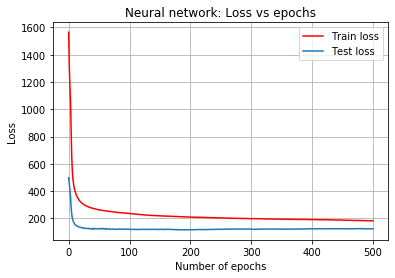

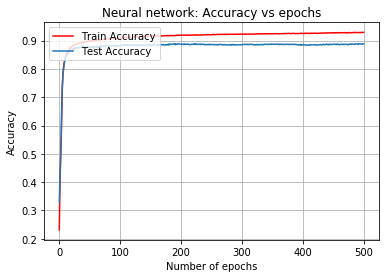

In [0]:
plt.plot(epoch_list, loss_list, color = 'red', label = 'Train loss')
plt.plot(epoch_list, loss_list_test, label = 'Test loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Neural network: Loss vs epochs")
plt.legend( loc = 'upper right')
plt.grid()
plt.show()

plt.plot(epoch_list, accuracy_list, color = "red", label = 'Train Accuracy')
plt.plot(epoch_list, accuracy_list_test, label = 'Test Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Neural network: Accuracy vs epochs")
plt.legend( loc = 'upper left')
plt.grid()
plt.show()

In [0]:
# network.parameters returns all the weights
for epoch in range(epochs):
  total_loss = 0
  total_correct = 0
  total_loss_test = 0
  total_correct_test = 0
  for batch in train_loader:
    images, labels = batch
    preds = network(images) # pass the batch
    loss = F.cross_entropy(preds, labels.type(torch.LongTensor).cuda()) 

    optimizer.zero_grad() # pytorch accumulates gradients so we have to zero 
    #gradients before we update the gradients zero_grad doenst work zero_grad()!
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    accuracy = total_correct/ len(train)
  for test_batch in test_loader:
    images, labels = test_batch
    preds = network(images)
    loss = F.cross_entropy(preds, labels.type(torch.LongTensor).cuda())
    total_loss_test += loss.item()
    total_correct_test += get_num_correct(preds, labels)
    accuracy_test = total_correct_test/ len(test)

  loss_list_test.append(total_loss_test)
  accuracy_list_test.append(accuracy_test)
  loss_list.append(total_loss)
  accuracy_list.append(accuracy)
  epoch_list.append(epoch)
  print( "epoch:", epoch, "loss", total_loss, "Accuracy: ", accuracy, "%", " Test loss", total_loss_test, "Accuracy Test: ", accuracy_test, "%")
 

NameError: ignored

In [0]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__() #we now have a network class that has all
    #the attributes of the pytorch nn module class
    self.conv1 = nn.Conv2d(in_channels= 3, out_channels = 6, kernel_size= 5)
    #kernel_size sets the filter size
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5)
    #fc = fully connected
    self.fc1 = nn.Linear(in_features = 12*5*5, out_features = 300)
    self.fc2 = nn.Linear(in_features = 300, out_features = 150)
    self.fc3 = nn.Linear(in_features = 150, out_features = 100)
    self.fc4 = nn.Linear(in_features = 100, out_features = 50)
    self.out = nn.Linear(in_features = 50, out_features = 10)

    self.localization = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size = 7),
        nn.MaxPool2d(2, stride = 2),
        nn.ReLU(True),
        nn.Conv2d(8, 15, kernel_size= 6),
        nn.MaxPool2d(2, stride = 2),
        nn.ReLU(True)
      )
    
    self.fc_loc = nn.Sequential(
        nn.Linear(15*4*4,32),
        nn.ReLU(True),
        nn.Linear(32, 3*2)
    )

    #self.fc_loc[2].weight.data.zero()
    #self.fc_loc[2].bias.data.copy_(torch.tensor[1, 0, 0, 0, 1, 0], dtype = torch.float)

  def stn(self,x):
    xs = self.localization(x)
    xs = xs.view(-1, 15*4*4)
    theta = self.fc_loc(xs)
    theta = theta.view(-1,2,3)

    grid = F.affine_grid(theta,x.size())
    x = F.grid_sample(x,grid)

    return x
  def forward(self, tensor):
    #input layer
    t = self.stn(tensor)

    # first hidden conv layer
    t = self.conv1(t) 
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size = 2, stride = 2) 
    # second hidden conv
    t = self.conv2(t)
    t = F.tanh(t)
    t = F.max_pool2d(t, kernel_size = 2, stride = 2)
    #hidden layer
    t = t.reshape(-1, 12*5*5)
    t = self.fc1(t)
    t = F.relu(t)
    #hidden layer
    t = self.fc2(t)
    t = F.relu(t)
    #hidden layer
    t = self.fc3(t)
    t = F.relu(t)
    #hidden layer
    t = self.fc4(t)
    t = F.relu(t)
    #output layer
    t = F.log_softmax(t, dim = 1)
    return t

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


UnboundLocalError: ignored